In [1]:
import csv
import pandas as pd
import scipy
import scipy.io
import scipy.integrate
import scipy.signal
from scipy.signal import argrelextrema
import numpy as np
from numpy import linalg
from pydmd import DMD
import matplotlib.pyplot as plt
from matplotlib import cm
import imageio
import math
import numpy.fft as fft

In [2]:
Re = 102500
n_modes = 10
plt.set_cmap("bwr")

mat = scipy.io.loadmat('D:\Documents\Year 3\FEEG3003 - IP\Airfoil Data\A0PIVuv.mat')
data = list(mat.items())

u = data[7]
u_mean = data[9]
v = data[8]
v_mean = data[10]
x = data[11]
y = data[12]
ts = data[3][1][0][0] # time step between snapshots
print(np.shape(u), u[0], np.shape(u_mean), u_mean[0], np.shape(v), v[0], np.shape(v_mean), v_mean[0])

samples = len(u[1])             # number of snapshots in input data
h = len(u[1][1][1])             # height of matrix = y
l = len(u[1][1])                # length of matrix = x
h_trunc = 35                    # y truncation for input data
l_trunc = 130-15                   # x truncation for input data
t_trunc = int(samples/2)                 # number of time snapshots for SVD

print(samples, h, l)

(2,) u (2,) u_mean (2,) v (2,) v_mean
6998 66 186


D:\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


<Figure size 432x288 with 0 Axes>

In [3]:
xs = []
for i in range(0, l_trunc):
    #xs.append(x[1][i][1])
    #xs.append(x[1][i][1])
    xs.append(i)
    
ys = []
for i in range(0,h_trunc*2):
    ys.append(i)
#ys = y[1][1][0:(h_trunc)]

(3499, 70, 115)


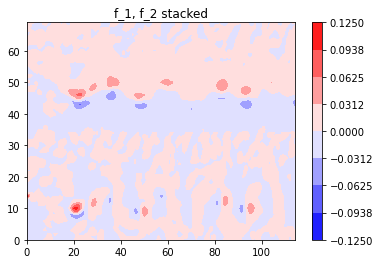

In [4]:
F = np.empty([t_trunc,h_trunc*2,l_trunc])
U = np.empty([t_trunc,h_trunc*2,l_trunc])
u_1 = []
u_2 = []
print(np.shape(F))
for i in range(0,t_trunc):
    u1 = np.rot90(u[1][i],3) # U dataset already has mean subtracted
    u1 = np.delete(u1, np.s_[h_trunc::], 0) # from top left, slice row 0:h. Parameter of 0 in np.delete defines rows
    u1 = np.delete(u1, np.s_[0:l-l_trunc], 1) # from top left, slice column 0:l. Parameter of 1 in np.delete defines columns
    u_1.append(u1)
    
    u2 = np.rot90(v[1][i]-v_mean[1][0],3) # V dataset requires mean to be subtracted
    u2 = np.delete(u2, np.s_[h_trunc::], 0) # from top left, slice row 0:h. Parameter of 0 in np.delete defines rows
    u2 = np.delete(u2, np.s_[0:l-l_trunc], 1) # from top left, slice column 0:l. Parameter of 1 in np.delete defines columns
    u_2.append(u2)
    
    du1_dx2,du1_dx1 = np.negative(np.gradient(u1)) # X gradients in y, x (check order in future)
    du2_dx2,du2_dx1 = np.negative(np.gradient(u2)) # Y gradients in y, x
    
    
    f_1 = np.multiply(u1, du1_dx1) + np.multiply(u2, du1_dx2) # U dataset
    f_2 = np.multiply(u1, du2_dx1) + np.multiply(u2, du2_dx2) # V dataset
    
    F[i,:,:] = np.append(f_1, f_2, axis=0)
    U[i,:,:] = np.append(u1, u2, axis=0)
    
fig, ax = plt.subplots()
levels = np.linspace(-0.125, 0.125, 9)
cs = ax.contourf(F[0], levels=levels)
ax.set_title('f_1, f_2 stacked')
fig.colorbar(cs, ax=ax)
plt.plot()
fig.canvas.draw()

In [5]:
print(np.shape(F))
# reshape X to contain all velocity points in second matrix dimension
F_trunc = np.transpose(np.reshape(F, (t_trunc,l_trunc*h_trunc*2)))
U_trunc = np.transpose(np.reshape(U, (t_trunc,l_trunc*h_trunc*2)))
print(np.shape(F_trunc))

(3499, 70, 115)
(8050, 3499)


In [6]:
#fig = plt.plot(scipy.linalg.svdvals(np.array([i.flatten() for i in X_trunc]).T), 'o')

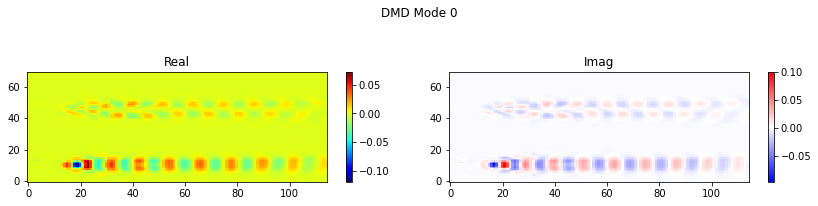

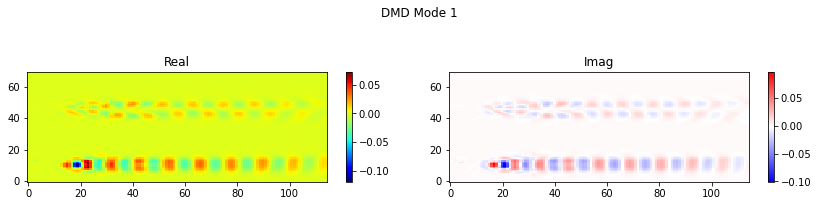

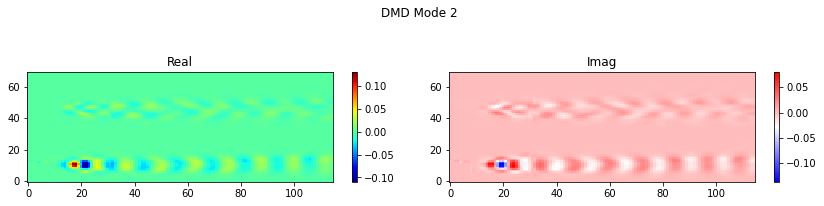

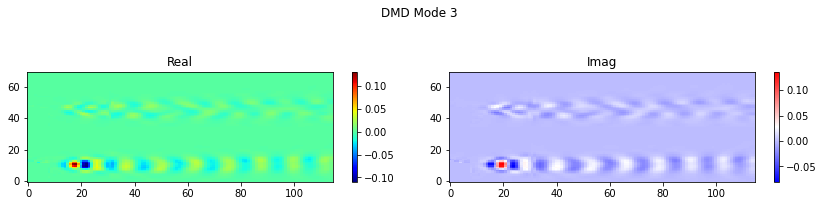

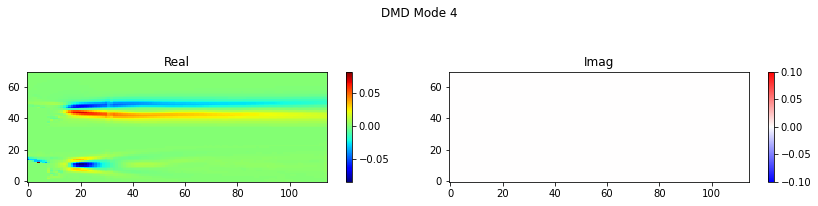

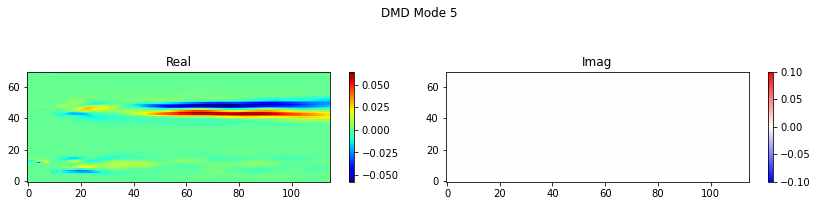

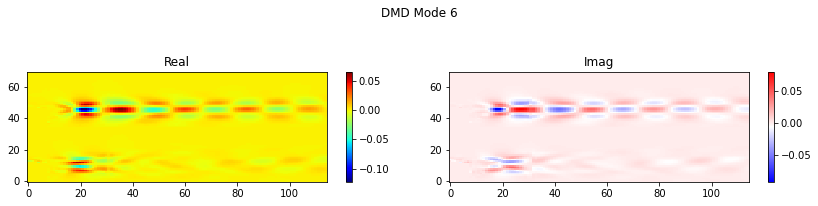

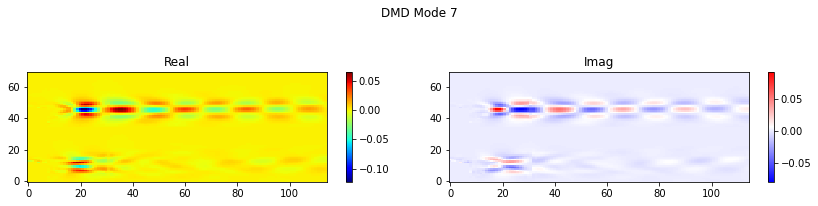

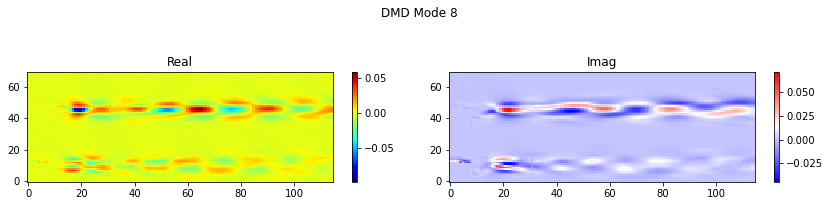

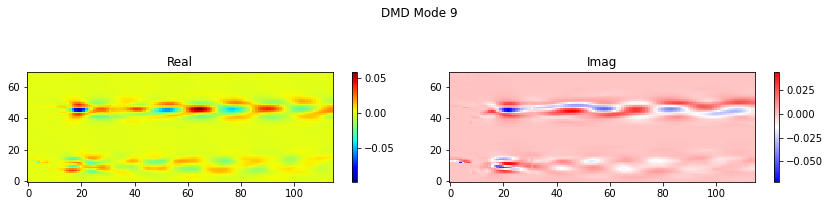

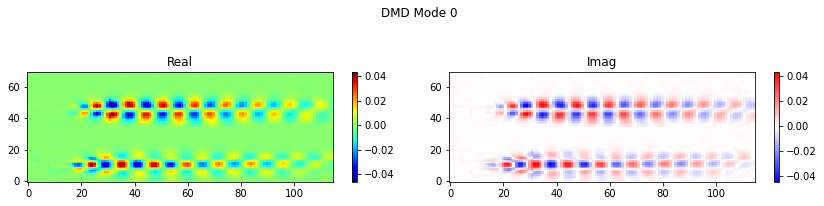

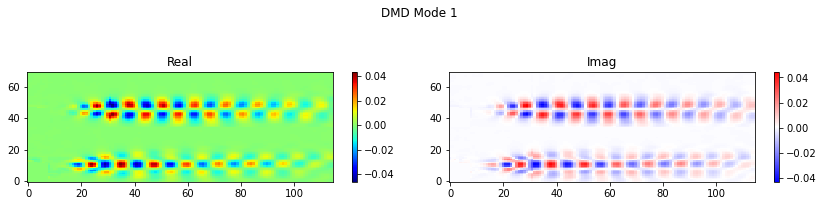

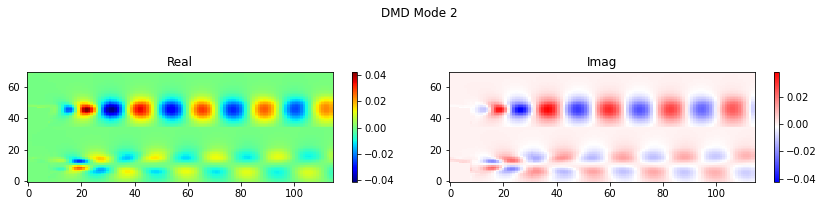

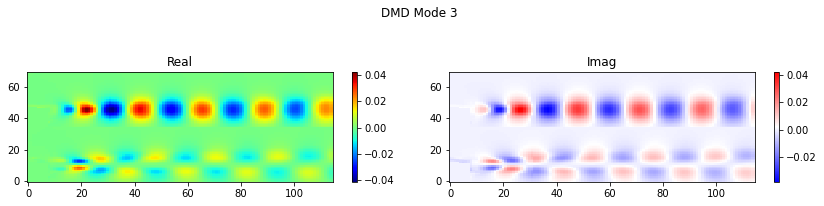

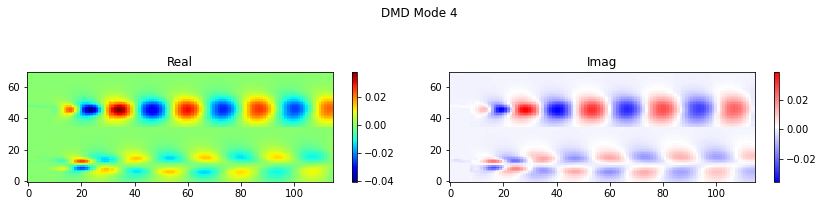

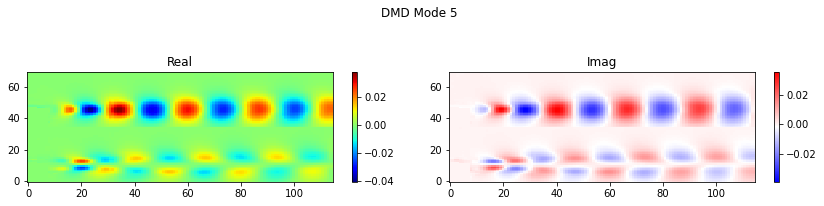

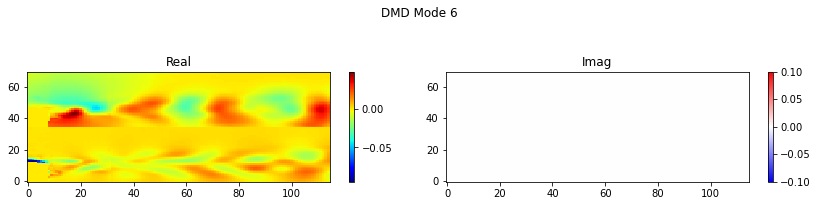

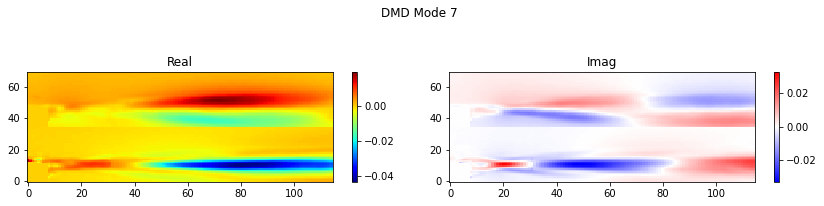

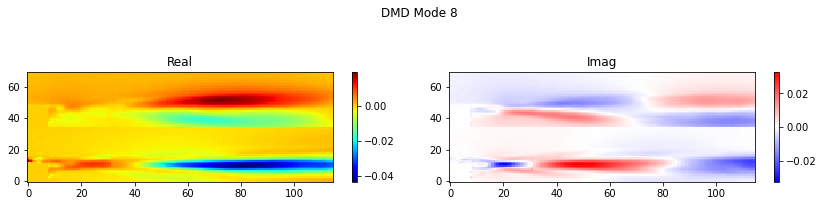

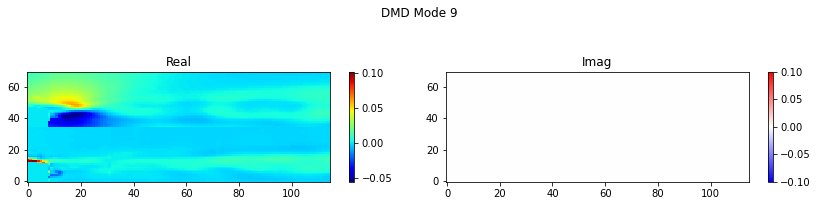

In [7]:
dmdF = DMD(svd_rank=n_modes, tlsq_rank=0, exact=True, opt=True) #svd_rank of 0 auto-selects truncation rank. In some cases, 
#singular values should be examined in order to select the proper truncation.

dmdF.fit(F_trunc)

dmdF.plot_modes_2D(x=xs, y=ys, figsize=(12,3))

dmdVel = DMD(svd_rank=n_modes, tlsq_rank=0, exact=True, opt=True)

dmdVel.fit(U_trunc)

dmdVel.plot_modes_2D(x=xs, y=ys, figsize=(12,3))

In [8]:
import csv
filename = "dmd_0_F.csv"
with open(filename, 'w') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerows(np.rot90(dmdF.modes.imag))
    csvwriter.writerows(np.rot90(dmdF.modes.real))

In [9]:
Freq = []
N = len(np.flip(fft.fft(dmdF.dynamics.real[0])))
sr = 1/ts # sampling rate, Hz
# Get the one-sided specturm
n_oneside = int(N/2)+1

for i in range(0,n_modes):
    time_coef = np.flip(fft.fft(dmdF.dynamics.real[i]))
    try:
        f = (argrelextrema(time_coef, np.greater)[0][0]+argrelextrema(time_coef, np.less)[0][0])/2*2*np.pi*sr/(2*n_oneside)
        if f < 100:
            Freq.append(np.round(f,1))
        else:
            Freq.append(0)
    except:
        Freq.append(0)
    print(Freq[i])
    
FreqV = []
print("U frequencies:")
N = len(np.flip(fft.fft(dmdVel.dynamics.real[0])))
sr = 1/ts # sampling rate, Hz
# Get the one-sided specturm
n_oneside = int(N/2)+1

for i in range(0,n_modes):
    time_coef = np.flip(fft.fft(dmdVel.dynamics.real[i]))
    try:
        f = (argrelextrema(time_coef, np.greater)[0][0]+argrelextrema(time_coef, np.less)[0][0])/2*2*np.pi*sr/(2*n_oneside)
        if f < 100:
            FreqV.append(np.round(f,1))
        else:
            FreqV.append(0)
    except:
        FreqV.append(0)
    print(FreqV[i])

24.2
24.2
22.0
22.0
0
0
12.3
12.3
8.2
8.2
U frequencies:
23.0
23.0
12.1
12.1
10.7
10.7
0
1.5
1.5
0


D:\Anaconda3\lib\site-packages\numpy\ma\core.py:2829: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy,


(10, 2, 35, 115)
(10, 35, 115)


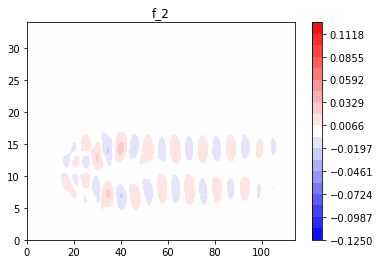

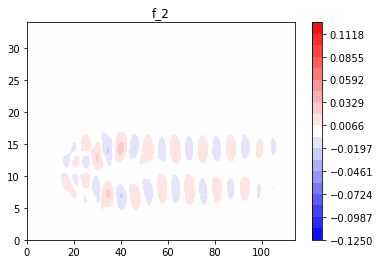

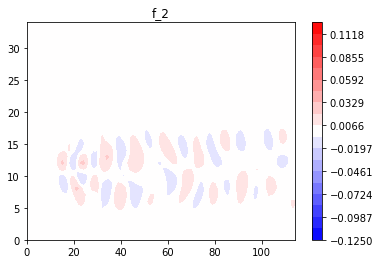

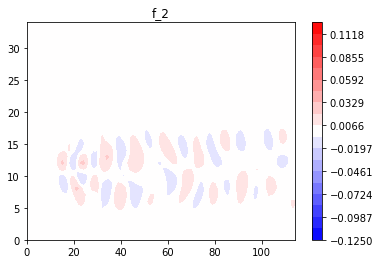

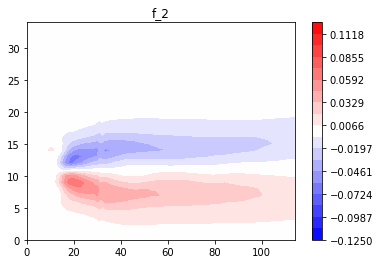

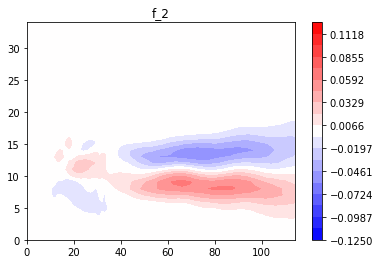

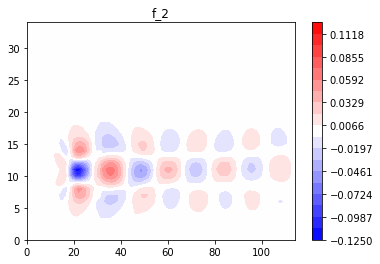

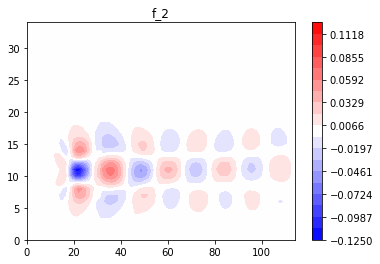

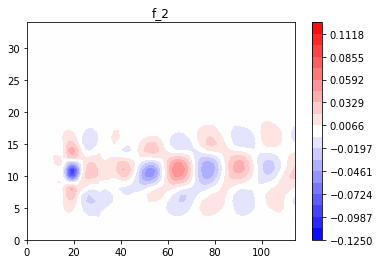

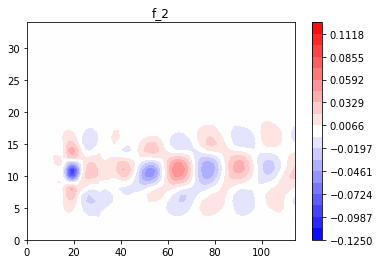

In [10]:
f_dmd_1 = []
f_dmd_2 = []

f_dmd_imag = []
f_dmd_real = []

for i in range(0, n_modes):
    # split U and V components for each real and imaginary part of each mode
    f_dmd_imag.append(np.vsplit(np.reshape(np.rot90(dmdF.modes.imag)[n_modes-1-i],(h_trunc*2,l_trunc)),2))
    f_dmd_real.append(np.vsplit(np.reshape(np.rot90(dmdF.modes.real)[n_modes-1-i],(h_trunc*2,l_trunc)),2))
    
    f_dmd_1.append(np.vectorize(complex)(f_dmd_real[i][1], f_dmd_imag[i][1])) # [1] index represents U component
    f_dmd_2.append(np.vectorize(complex)(f_dmd_real[i][0], f_dmd_imag[i][0])) # [0] index represents V component
    
    fig, ax = plt.subplots()
    levels = np.linspace(-0.125, 0.125, 20)
    cs = ax.contourf(f_dmd_1[i], levels=levels)
    ax.set_title('f_2')
    fig.colorbar(cs, ax=ax)
    plt.plot()
    fig.canvas.draw()
    
V_dmd_1 = []
V_dmd_2 = []

V_dmd_imag = []
V_dmd_real = []

for i in range(0, n_modes):
    # split U and V components for each real and imaginary part of each mode
    V_dmd_imag.append(np.vsplit(np.reshape(np.rot90(dmdVel.modes.imag)[n_modes-1-i],(h_trunc*2,l_trunc)),2))
    V_dmd_real.append(np.vsplit(np.reshape(np.rot90(dmdVel.modes.real)[n_modes-1-i],(h_trunc*2,l_trunc)),2))
    
    V_dmd_1.append(np.vectorize(complex)(V_dmd_real[i][1], V_dmd_imag[i][1])) # [1] index represents U component
    V_dmd_2.append(np.vectorize(complex)(V_dmd_real[i][0], V_dmd_imag[i][0])) # [0] index represents V component

print(np.shape(f_dmd_imag))
print(np.shape(f_dmd_1))

In [11]:
# Mode numbers paired to plot. Must both be in frequency space.
f_n = [2,6]
u_n = [0,2]

N = []
for i in range(0, len(f_n)):
    
    N.append(np.negative(
            np.multiply(np.transpose(np.matrix(V_dmd_1[u_n[i]]).getH()),f_dmd_1[f_n[i]]) +
            np.multiply(V_dmd_1[u_n[i]],np.transpose(np.matrix(f_dmd_1[f_n[i]]).getH())) +
            np.multiply(np.transpose(np.matrix(V_dmd_2[u_n[i]]).getH()),f_dmd_2[f_n[i]]) +
            np.multiply(V_dmd_2[u_n[i]],np.transpose(np.matrix(f_dmd_2[f_n[i]]).getH()))
        ))

[]

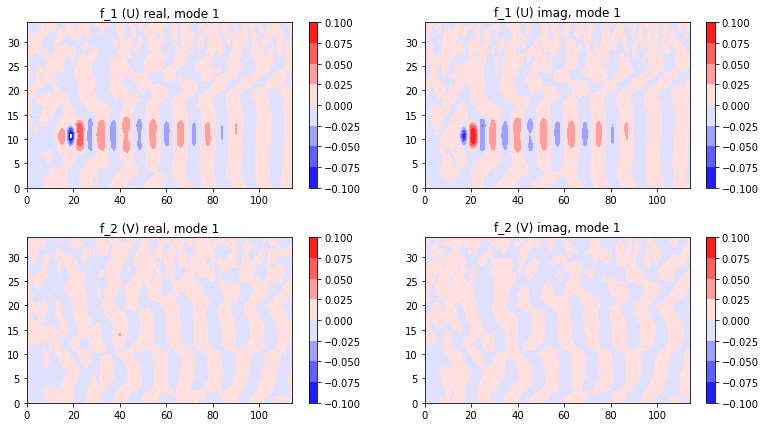

In [12]:
fig, axes = plt.subplots(2, 2, figsize = (15,7))
n = 0    # Mode number we are plotting
term = [f_dmd_real[n][0], f_dmd_imag[n][0], f_dmd_real[n][1], f_dmd_imag[n][1]]
term_name = ["f_1 (U) real, mode "+str(n+1), "f_1 (U) imag, mode "+str(n+1), "f_2 (V) real, mode "+str(n+1), "f_2 (V) imag, mode "+str(n+1)]
for ax in axes.flat:
    levels = np.linspace(-0.1, 0.1, 9)
    cs = ax.contourf(term[n], levels = levels)
    ax.set_title(term_name[n])
    fig.colorbar(cs, ax=ax)
    n = n+1

fig.subplots_adjust(hspace = 0.3)
fig.subplots_adjust(right=0.8)
plt.plot()

[]

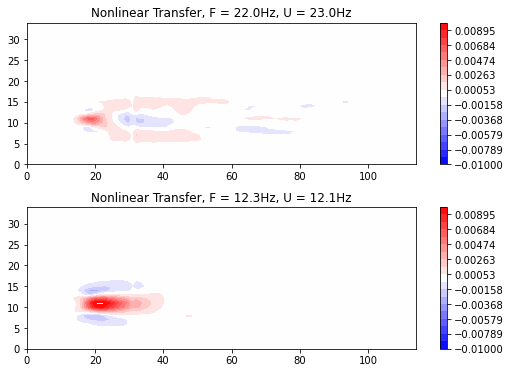

In [16]:
fig, axes = plt.subplots(len(f_n), 1, figsize = (10,6))
n = 0
for ax in axes.flat:
    levels = np.linspace(-0.01, 0.01, 20)
    cs = ax.contourf(N[n], levels = levels)
    #cs = ax.contourf(N[n])
    ax.set_title('Nonlinear Transfer, F = ' + str(Freq[f_n[n]]) + 'Hz, U = ' + str(FreqV[u_n[n]]) + 'Hz')
    fig.colorbar(cs, ax=ax)
    n = n+1
    
fig.subplots_adjust(hspace = 0.3)
fig.subplots_adjust(right=0.8)

plt.plot()

# Fixed the order of U and V components in f after DMD to give correct figures.

In [14]:
#dissipation for A10